In [1]:
# Import Statements 
####################
import os 
import sys
import copy
import pandas as pd
import pathlib as pl
import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image, ImageDraw
import pathlib
import datetime
import itertools as ite 
import math
import calendar

import shapefile  #conda install -c conda-forge pyshp    # (version should be 2.0)
from shapely.geometry import Point   #conda install -c conda-forge shapely
from shapely.geometry import shape


NUM_TIME_BINS_PER_DAY = 24

In [2]:
_="""

Define any useful functions 

"""

def cleanURL(url):
    p = pathlib.Path(url)
    path = str(p.as_posix()) 
    return path 


def getDF(loc, sheetname):
    dataframe = pd.read_excel(loc, sheetname)
    #https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
    dataframe = dataframe.applymap(lambda x: x.strip() if type(x) is str else x)
    return dataframe

def printNulls(df):
    null_columns = df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum() 


def writeDFToFile(dfs, path_): #dfs is an array of dataframes and their sheet names , path needs to have
    time_ = str(datetime.datetime.now())
    current_date_time = time_[0:time_.index(".")]
    current_date_time = current_date_time.replace(":", "-")
    task4_fileoutput = path_+current_date_time+".xlsx"

    writer = pd.ExcelWriter(task4_fileoutput)
    
    for df_tuple in dfs:  
        df = df_tuple[0]
        sheetName = df_tuple[1]
        df.to_excel(writer, sheetName)
    print("file written to :       " + task4_fileoutput)
    writer.save()



Useful GIS functions

# Buildings

In [45]:
#Save final_dataframe for reference
#final_dataframe.to_csv(cleanURL(r'C:\Users\j70514\Documents\Data Science Stuff\DeepLearning_cs230\CNN_data_crunch/buildOff3.csv') , sep = ',' )


# Really, after we finalize input dataset
# retrieve final_dataframe and start from here
buildings =pd.read_csv(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\Buildings.csv')) # csv version of Sean's building data
# final_dataframe['Date'] = pd.to_datetime(final_dataframe['Date'], format ='%Y-%m-%d %H:%M:%S')
print('done')
# assert(final_dataframe.Date)

done


In [46]:
buildings.head()


,Unnamed: 0,Condition,Stories,Units,Square Footage,Footprint
0,0,SOUND,0,1,2196,MULTIPOLYGON (((-87.6667306636366 41.707976033...
1,1,SOUND,0,1,1927,MULTIPOLYGON (((-87.74054777420343 41.98823925...
2,2,SOUND,0,1,1583,MULTIPOLYGON (((-87.79346762796452 41.93182544...
3,5,SOUND,0,1,1034,MULTIPOLYGON (((-87.80273335405644 42.00018304...
4,6,SOUND,0,2,2967,MULTIPOLYGON (((-87.62162454057852 41.83264364...


In [48]:
printNulls(buildings)
abc = buildings.head().copy()
# abc.iat[0,0] = np.nan
# abc.head()
printNulls(buildings)
len(buildings)

453046

In [7]:
#Learning how to take in the polygon
cols = buildings.columns.tolist()
footprintIndex = cols.index('Footprint')

point_ = (buildings.iat[0,footprintIndex])
point_


'MULTIPOLYGON (((-87.6667306636366 41.707976033242225, -87.66686799082457 41.70797682976896, -87.66686709803044 41.70806327088082, -87.66668398069386 41.70806358088659, -87.66668285842599 41.70799496621002, -87.66673046519738 41.70799524237778, -87.6667306636366 41.707976033242225)))'

In [17]:
#https://stackoverflow.com/questions/51855917/shapely-polygon-from-string
import shapely.wkt
P = shapely.wkt.loads(point_)
print(type(P))

polygons = list(P)
polygons

<class 'shapely.geometry.multipolygon.MultiPolygon'>


-87.66677543431237 41.7080292566293


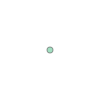

In [34]:
polygon = polygons[0]
print(polygon.representative_point().x, polygon.representative_point().y)
polygon.representative_point() # https://gis.stackexchange.com/questions/43384/python-find-a-method-to-calculate-the-inner-centroid-also-known-as-labelpoin


-87.66677932212998
41.708021849277095


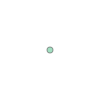

In [33]:
print(polygon.centroid.x)
print(polygon.centroid.y)
polygon.centroid


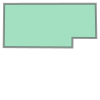

In [27]:
polygon

In [15]:
# writing real code : 
#check if all multipolygons have just one polygon
for rIndex in range(len(buildings)):
    stringMultipolygon = buildings.iat[rIndex,footprintIndex]
    multiPolygon = shapely.wkt.loads(stringMultipolygon)
    polygons = list(multiPolygon)
    try:
        assert(len(polygons)==1)
    except:
        print('more than one polygon found : ', rIndex)
print('done')

more than one polygon found :  9964
more than one polygon found :  23211
more than one polygon found :  37846
more than one polygon found :  54461
more than one polygon found :  57690
more than one polygon found :  75685
more than one polygon found :  127777
more than one polygon found :  166039
more than one polygon found :  204767
more than one polygon found :  207119
more than one polygon found :  258351
more than one polygon found :  271799
more than one polygon found :  277773
more than one polygon found :  284462
more than one polygon found :  286352
more than one polygon found :  290518
more than one polygon found :  313008
more than one polygon found :  327670
more than one polygon found :  327741
more than one polygon found :  340414
more than one polygon found :  452808
done


In [49]:
#good looks like there are not that many multipolygons -> filter them out

#real code here, loop through each multipolygon, extract the
def functionToApply(row):
    stringMultipolygon = row['Footprint']
    multiPolygon = shapely.wkt.loads(stringMultipolygon)
    polygons = list(multiPolygon)
    if(len(polygons) ==1): #if not we just return None
        return str(polygons[0].centroid.x)+","+str(polygons[0].centroid.y)
    else:
        return 'none'

buildings['longlat'] = buildings.apply(functionToApply, axis = 1)
print('done')

done


In [50]:
print(len(buildings))
buildings = buildings.loc[~(buildings['longlat']=='none')].copy()
print(len(buildings))


453046
453025


In [51]:
#write to file
buildings[['long', 'lat']] = buildings['longlat'].str.split(',', expand = True)


In [52]:
buildings.to_csv(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\BuildingsParsed.csv') , sep = ',' )
print('done')

done


# L Entries

In [94]:
LEntries =pd.read_csv(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\LEntries.csv')) # csv version of Sean's building data
# final_dataframe['Date'] = pd.to_datetime(final_dataframe['Date'], format ='%Y-%m-%d %H:%M:%S')
print('done')

done


In [95]:
LEntries.head()

,Unnamed: 0,Date,Entries,Location,Green Line,Red Line,Brown Line,Purple Line,Yellow Line,Blue Line,Pink Line,Orange Line
0,0,01/01/2001,290,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False
1,1,01/02/2001,1240,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False
2,2,01/03/2001,1412,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False
3,3,01/04/2001,1388,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False
4,4,01/05/2001,1465,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False


In [96]:
LEntries.dtypes

Unnamed: 0      int64
Date           object
Entries         int64
Location       object
Green Line       bool
Red Line         bool
Brown Line       bool
Purple Line      bool
Yellow Line      bool
Blue Line        bool
Pink Line        bool
Orange Line      bool
dtype: object

In [97]:
LEntries = LEntries.dropna()
printNulls(LEntries)

Series([], dtype: float64)

In [98]:

LEntries.head()

,Unnamed: 0,Date,Entries,Location,Green Line,Red Line,Brown Line,Purple Line,Yellow Line,Blue Line,Pink Line,Orange Line
0,0,01/01/2001,290,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False
1,1,01/02/2001,1240,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False
2,2,01/03/2001,1412,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False
3,3,01/04/2001,1388,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False
4,4,01/05/2001,1465,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False


In [99]:
import shapely.wkt

def functionToApplyLEntries(row):
    pointStr = row['Location']
    point_ = shapely.wkt.loads(pointStr)
    return str(point_.x)+","+str(point_.y)

LEntries['longlat'] = LEntries.apply(functionToApplyLEntries, axis = 1)
print('done')

done


In [100]:
#write to file
LEntries[['long', 'lat']] = LEntries['longlat'].str.split(',', expand = True)

In [101]:
LEntries.head()

,Unnamed: 0,Date,Entries,Location,Green Line,Red Line,Brown Line,Purple Line,Yellow Line,Blue Line,Pink Line,Orange Line,longlat,long,lat
0,0,01/01/2001,290,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False,"-87.77678526925516,41.87088639373663",-87.77678526925516,41.87088639373663
1,1,01/02/2001,1240,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False,"-87.77678526925516,41.87088639373663",-87.77678526925516,41.87088639373663
2,2,01/03/2001,1412,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False,"-87.77678526925516,41.87088639373663",-87.77678526925516,41.87088639373663
3,3,01/04/2001,1388,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False,"-87.77678526925516,41.87088639373663",-87.77678526925516,41.87088639373663
4,4,01/05/2001,1465,POINT (-87.77678526925516 41.87088639373663),False,False,False,False,False,True,False,False,"-87.77678526925516,41.87088639373663",-87.77678526925516,41.87088639373663


In [102]:
LEntries.to_csv(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\LEntriesParsed.csv') , sep = ',' )
print('done')

done


In [103]:
len(LEntries.loc[LEntries['Date']=='01/01/2001'])

138

In [104]:
# writeDFToFile(dfs=[(LEntries, 'Sheet1')], path_=cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\LEntriesParsed1.xlsx') )
LEntries = None